In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori,fpgrowth,association_rules
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Read the original data file.
df = pd.read_excel('../input/bank-loan-dataset/Bank_Personal_Loan_Modelling.xlsx', sheet_name='Data')
df.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4.0,1.6,1,0.0,0,1,0.0,0,0.0
1,2,45,19,34,90089,3.0,1.5,1,0.0,0,1,0.0,0,0.0
2,3,39,15,11,94720,1.0,1.0,1,0.0,0,0,0.0,0,0.0
3,4,39,15,11,94720,1.0,1.0,1,0.0,0,0,0.0,0,0.0
4,5,35,8,45,91330,4.0,1.0,2,0.0,0,0,0.0,0,1.0


In [3]:
# Remove the index column.
df.drop('ID', axis=1, inplace=True) 

In [4]:
# View columns with missing values in the data.
print(df.isnull().any())

Age                   False
Experience            False
Income                False
ZIP Code              False
Family                 True
CCAvg                 False
Education             False
Mortgage               True
Personal Loan         False
Securities Account    False
CD Account             True
Online                False
CreditCard             True
dtype: bool


In [5]:
# Fill missing values using mean.
df=df.fillna(df.mean())

In [6]:
# Check the columns with missing values in the data again and find that the missing values has been filled in.
print(df.isnull().any())

Age                   False
Experience            False
Income                False
ZIP Code              False
Family                False
CCAvg                 False
Education             False
Mortgage              False
Personal Loan         False
Securities Account    False
CD Account            False
Online                False
CreditCard            False
dtype: bool


In [7]:
# Calculate the cosine similarity of the data and the distance between the data.
cosine_similarity(df)
pairwise_distances(df,metric="cosine")

array([[0.00000000e+00, 5.82457188e-08, 1.09847160e-07, ...,
        1.31899668e-06, 3.93853957e-06, 1.30643835e-07],
       [5.82457188e-08, 0.00000000e+00, 3.97023900e-08, ...,
        1.30553165e-06, 4.19763083e-06, 1.16122359e-07],
       [1.09847160e-07, 3.97023900e-08, 0.00000000e+00, ...,
        1.35350369e-06, 4.68108384e-06, 2.88719810e-07],
       ...,
       [1.31899668e-06, 1.30553165e-06, 1.35350369e-06, ...,
        0.00000000e+00, 1.63983124e-06, 1.39782712e-06],
       [3.93853957e-06, 4.19763083e-06, 4.68108384e-06, ...,
        1.63983124e-06, 1.11022302e-16, 3.50872950e-06],
       [1.30643835e-07, 1.16122359e-07, 2.88719810e-07, ...,
        1.39782712e-06, 3.50872950e-06, 1.11022302e-16]])

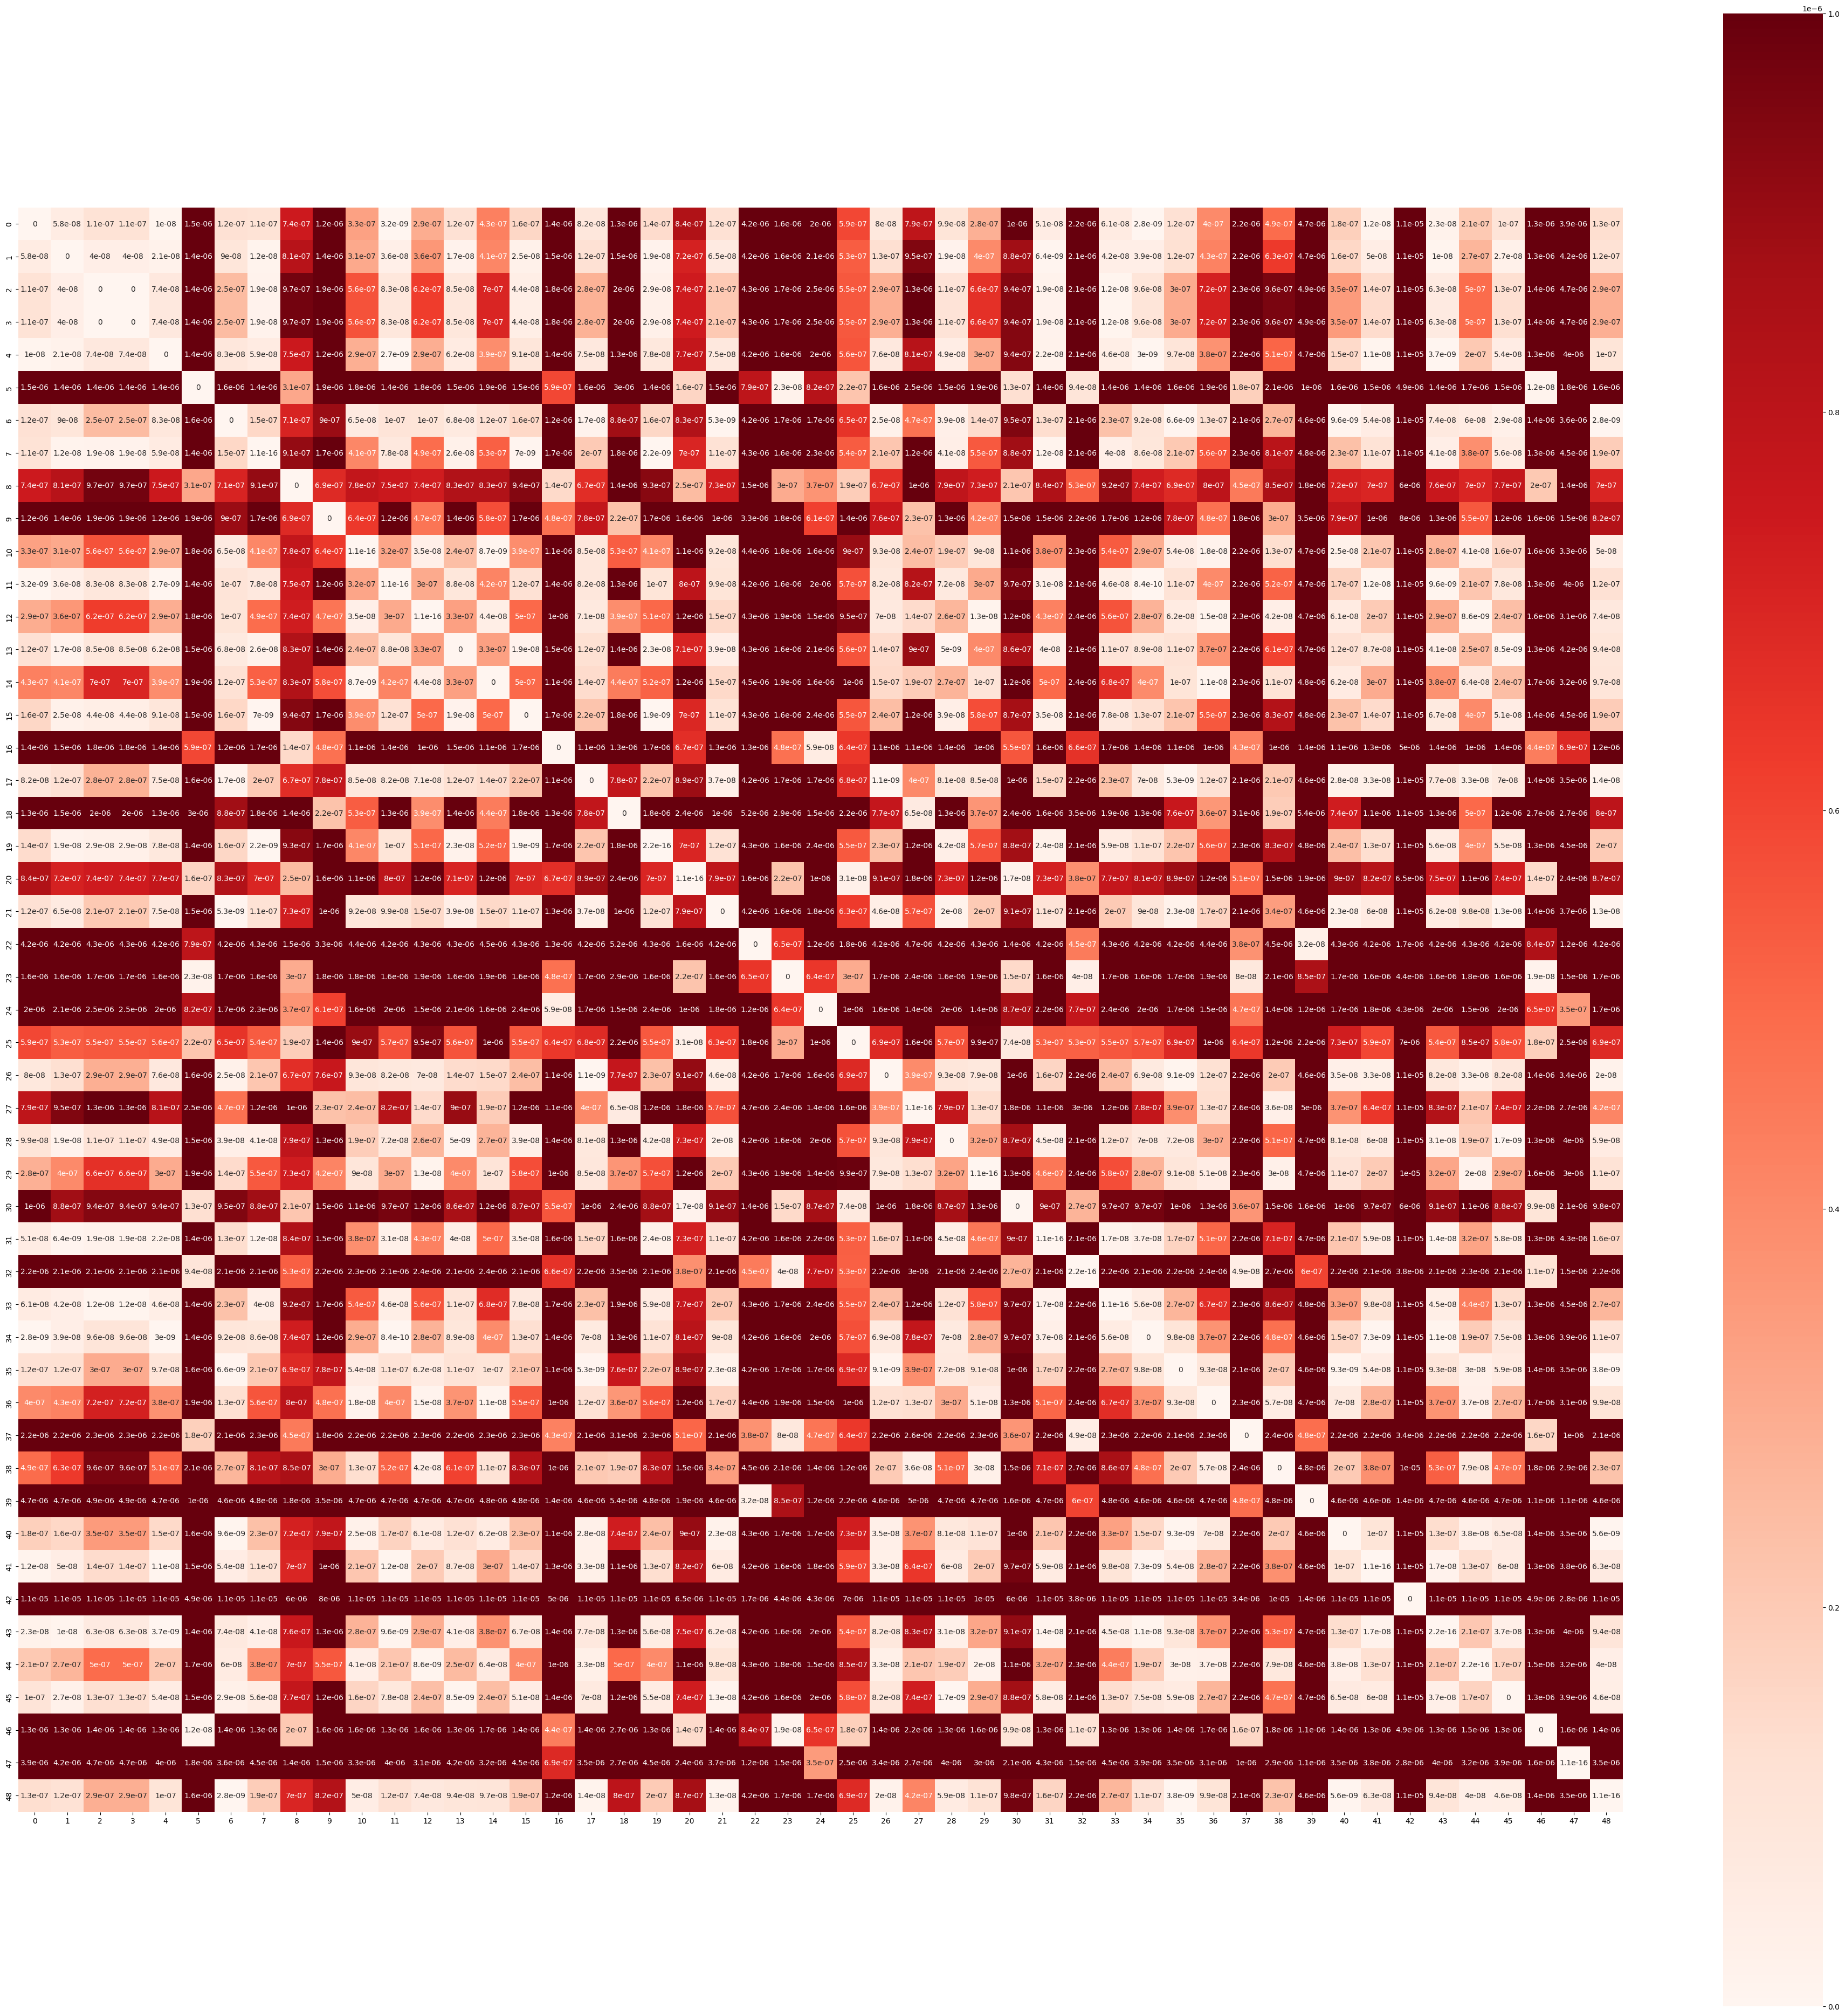

In [8]:
# Draw a heat map based on the distance of the data.
plt.subplots(figsize = (48,48))
sns.heatmap(pairwise_distances(df,metric='cosine'),annot = True,vmax = 0.000001,square = True,cmap = "Reds")
plt.show()

In [9]:
# It can be seen from the heat map that the distance between data 3 and 4 is 0 and the similarity is 100%. So delete the 4th row of the data.
print(len(df))
df=df.drop(4,axis = 0) 
print(len(df))

49
48


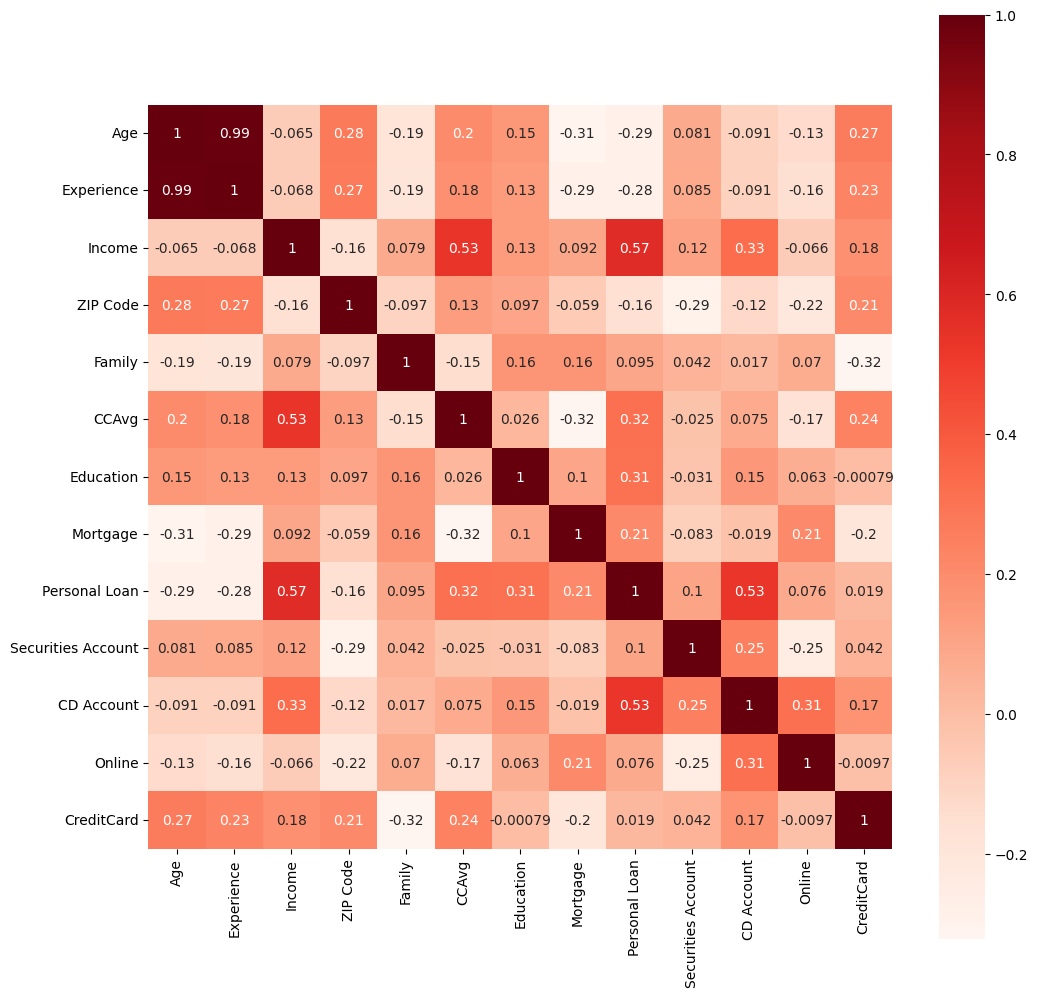

In [10]:
# Draw the correlation hotspot map of each column of the data.
plt.subplots(figsize = (12,12))
sns.heatmap(df.corr('spearman'),annot = True,vmax = 1,square = True,cmap = "Reds")
plt.show()

In [11]:
# Based on the map, the Age and Experience columns are highly correlated. Delete one of the columns and view the latest column information.
df.drop('Age', axis=1, inplace=True)
df.columns

Index(['Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'Personal Loan', 'Securities Account', 'CD Account',
       'Online', 'CreditCard'],
      dtype='object')

In [12]:
# Preprocess the data to facilitate correlation analysis.
df_for_apriori = df.drop('ZIP Code',axis=1).astype(int).reset_index()

# Convert the data into sparse matrix format.
list1 = []
for row in range(len(df_for_apriori)):
    list2 = []
    for column in range(1,len(df_for_apriori.columns)):
        str_term = '%s_%d' % (df_for_apriori.columns[column],df_for_apriori[df_for_apriori.columns[column]][row])
        list2.append(str_term)
    list1.append(list2)
te = TransactionEncoder()
list1_tf = te.fit_transform(list1)
list1_df = pd.DataFrame(list1_tf,columns=te.columns_)

In [13]:
# Use the Apriori algorithm for correlation analysis, and the minimum support is set to 0.1.
frequent_itemsets = apriori(list1_df, min_support=0.1, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False, inplace=True)

# Find association rules, and discover rules through confidence threshold.
rule = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rule["antelen"] = rule.antecedents.apply(lambda x:len(x))
rule = rule[(rule.antelen == 1) & (rule.lift > 1)]
rule.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antelen
0,(Personal Loan_0),(CD Account_0),0.854167,0.937500,0.854167,1.000000,1.066667,0.053385,inf,0.428571,1
1,(CD Account_0),(Personal Loan_0),0.937500,0.854167,0.854167,0.911111,1.066667,0.053385,1.640625,1.000000,1
2,(Securities Account_0),(CD Account_0),0.812500,0.937500,0.791667,0.974359,1.039316,0.029948,2.437500,0.201754,1
3,(CD Account_0),(Securities Account_0),0.937500,0.812500,0.791667,0.844444,1.039316,0.029948,1.205357,0.605263,1
4,(CD Account_0),(CreditCard_0),0.937500,0.750000,0.729167,0.777778,1.037037,0.026042,1.125000,0.571429,1


From the above results, we can see that there is a high degree of support between not having a deposit/credit card/securities account in the bank and not having a loan from the bank, which is also in line with basic common sense.

In [14]:
# Analyze the relationship between loans and banks.
rule[rule['antecedents'] == frozenset({'Personal Loan_1'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antelen
2473,(Personal Loan_1),(Education_3),0.145833,0.416667,0.104167,0.714286,1.714286,0.043403,2.041667,0.487805,1


It can be clearly found that if a person borrows money from a bank, the probability that this person has a high education level is very high.

In [15]:
# Using the FP-Growth algorithm to find association rules.
frequent_itemsets = fpgrowth(list1_df, min_support=0.1, use_colnames=True)

# Find association rules, and discover rules through confidence threshold.
rule = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rule["antelen"] = rule.antecedents.apply(lambda x:len(x))
rule = rule[(rule.antelen == 1) & (rule.lift > 1)]
rule.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antelen
0,(Personal Loan_0),(CD Account_0),0.854167,0.937500,0.854167,1.000000,1.066667,0.053385,inf,0.428571,1
1,(CD Account_0),(Personal Loan_0),0.937500,0.854167,0.854167,0.911111,1.066667,0.053385,1.640625,1.000000,1
2,(CD Account_0),(CreditCard_0),0.937500,0.750000,0.729167,0.777778,1.037037,0.026042,1.125000,0.571429,1
3,(CreditCard_0),(CD Account_0),0.750000,0.937500,0.729167,0.972222,1.037037,0.026042,2.250000,0.142857,1
4,(Personal Loan_0),(CreditCard_0),0.854167,0.750000,0.645833,0.756098,1.008130,0.005208,1.025000,0.055300,1


In [16]:
rule.lift.unique()

array([1.06666667, 1.03703704, 1.00813008, 1.0369338 , 1.01978022,
       1.01754386, 1.06097561, 1.13170732, 1.01470588, 1.0302439 ,
       1.14      , 1.01333333, 1.216     , 1.19172414, 1.04228571,
       1.17073171, 1.14705882, 1.35529412, 1.22352941, 1.26572008,
       1.54010695, 1.09297913, 1.07958478, 1.12820513, 1.04142012,
       1.16043956, 1.27320955, 1.06882591, 1.22222222, 1.07317073,
       1.25714286, 1.29032258, 1.49333333, 1.16666667, 1.6969697 ,
       1.33333333, 1.06430155, 1.09090909, 1.40762463, 1.24675325,
       1.58677686, 1.02673797, 1.20376176, 1.39636364, 1.03931624,
       1.0206379 , 1.04749679, 1.07692308, 1.02439024, 1.125     ,
       1.02631579, 1.05882353, 1.12374582, 1.09839817, 1.16624041,
       1.09756098, 1.08333333, 1.11428571, 1.25806452, 1.24137931,
       1.44      , 1.8972332 , 1.11888112, 2.07792208, 1.03349282,
       1.96363636, 1.12207792, 1.35423197, 2.31016043, 2.45454545,
       1.12609971, 1.83732057, 2.32727273, 1.01052632, 1.25   

In [17]:
rule[rule['antecedents'] == frozenset({'Personal Loan_1'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antelen
2963,(Personal Loan_1),(Education_3),0.145833,0.416667,0.104167,0.714286,1.714286,0.043403,2.041667,0.487805,1


It can be seen that the results obtained by the two algorithms are basically the same.

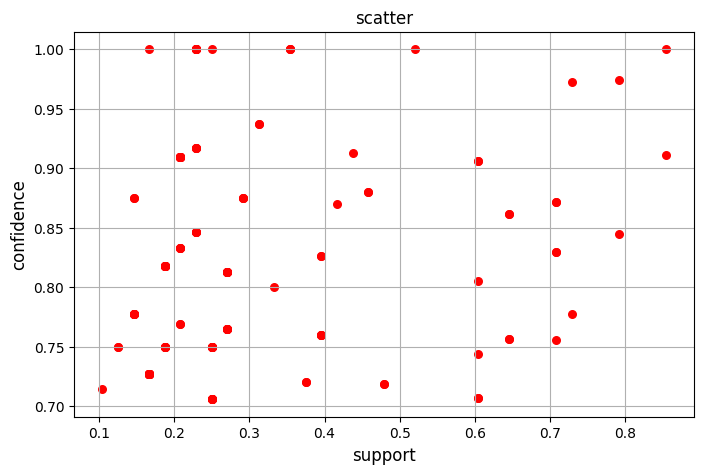

In [18]:
# Draw a scatter plot of support and confidence.
rule.plot(kind="scatter",x = "support",c = "r",
           y = "confidence",s = 30,figsize=(8,5))
plt.grid("on")
plt.xlabel("support",size = 12)
plt.ylabel("confidence",size = 12)
plt.title("scatter")
plt.show()

In [19]:
# Select eigenvalues and predicted values, and divide 20% of the data into test sets and 80% into training sets.
X = df_for_apriori[['Experience','Income','Family','CCAvg','Education','Mortgage','Securities Account','CD Account','Online','CreditCard']]
y = df_for_apriori['Personal Loan']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [20]:
# View training sets data.
X_train.head()

,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
8,9,180,1,8,3,57,0,0,0,0
3,15,11,1,1,1,0,0,0,0,0
6,24,22,1,0,3,0,0,0,0,1
39,32,84,3,1,3,0,1,0,0,0
33,5,50,4,1,3,0,0,0,1,0


In [21]:
# View test sets data.
X_test.head()

,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
27,30,48,1,2,3,0,0,0,1,1
40,9,60,3,2,1,0,0,0,0,0
26,20,158,1,2,1,0,0,0,1,1
43,20,104,1,5,1,0,0,0,1,1
24,19,29,3,0,1,97,0,0,1,0


In [22]:
%%capture
# Define the K nearest neighbor model, and classify the categories into two categories, loan and no loan.
clf = KNeighborsClassifier(n_neighbors=2)    
clf.fit(X_train, y_train)

In [23]:
# Predict the test set results and display the accuracy.
correct = np.count_nonzero((clf.predict(X_test)==y_test)==True)    
print ("Accuracy is: %.3f" %(correct/len(X_test)))

Accuracy is: 0.800


In [24]:
# Use KMeans algorithm for cluster analysis, and divide the categories into 4 categories.
X = df_for_apriori
n_clusters = 4
cluster = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
y_pred = cluster.labels_
X ['y_pred'] = y_pred

<AxesSubplot: >

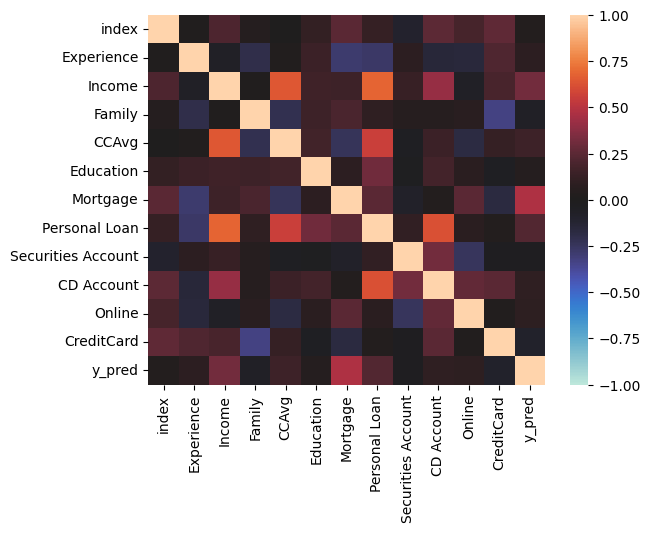

In [25]:
sns.heatmap(X.corr(), vmax=1, vmin=-1, center=0)

By analyzing the correlation between each column and the forecast category, we can find that Income and Mortgage have the greatest correlation with the category of the score.

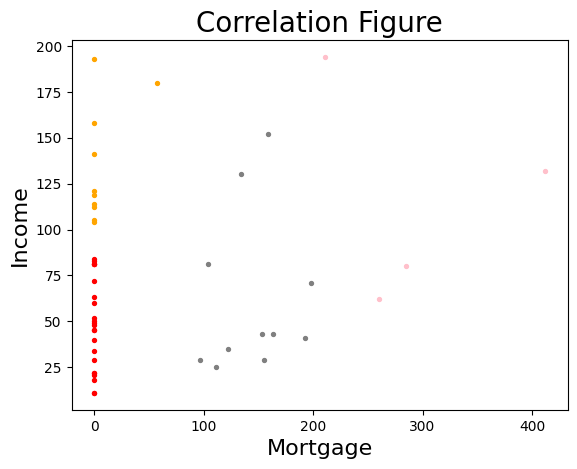

In [26]:
# Draw the clustering results based on Income and Mortgage data.
color = ["red","pink","orange","gray"]
fig, ax1 = plt.subplots(1)
for i in range(len(X)):
    ax1.scatter(X['Mortgage'][i], X['Income'][i],marker='o',s=8,c=color[X['y_pred'][i]])
plt.xlabel("Mortgage", fontdict={'size': 16})
plt.ylabel("Income", fontdict={'size': 16})
plt.title("Correlation Figure", fontdict={'size': 20})
plt.show()